In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

In [16]:
transactions = pd.read_csv('data/Small_HI/HI-Small_Trans.csv')
transactions.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


In [17]:
transactions.drop_duplicates(inplace=True)
transactions = transactions[~(transactions.isin(['-', '?'])).any(axis=1)]

In [18]:
transactions['Timestamp'] = pd.to_datetime(transactions['Timestamp'])

In [35]:
transactions.dtypes

Timestamp             datetime64[ns]
From Bank                      int64
Account                       object
To Bank                        int64
Account.1                     object
Amount Received              float64
Receiving Currency            object
Amount Paid                  float64
Payment Currency              object
Payment Format                object
Is Laundering                  int64
dtype: object

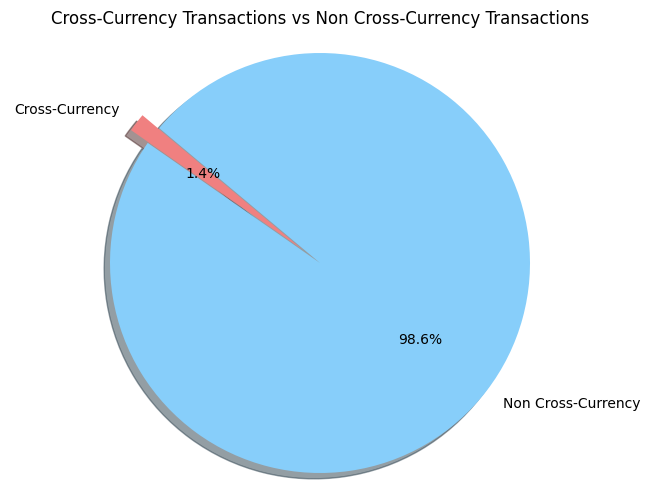

In [41]:
cross_currency_transactions = transactions[transactions['Receiving Currency'] != transactions['Payment Currency']]
same_currency_transactions = transactions[transactions['Receiving Currency'] == transactions['Payment Currency']]
cross_currency_count = cross_currency_transactions.shape[0]

total_transactions = transactions.shape[0]

non_cross_currency_count = same_currency_transactions.shape[0]

labels = ['Cross-Currency', 'Non Cross-Currency']
sizes = [cross_currency_count, non_cross_currency_count]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Cross-Currency Transactions vs Non Cross-Currency Transactions')
plt.axis('equal')
plt.show()

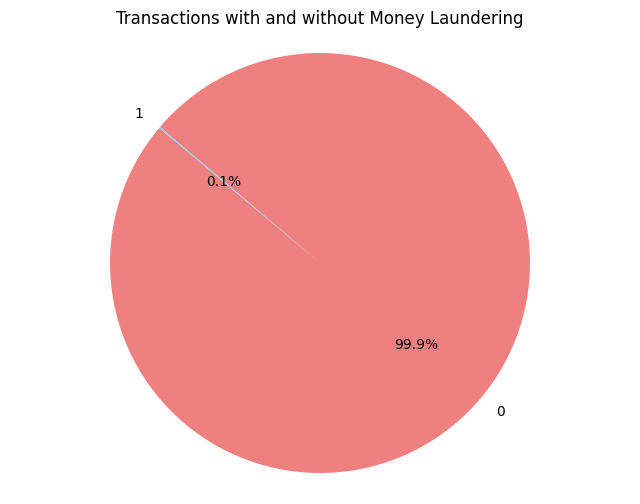

In [47]:
laundering_counts = transactions['Is Laundering'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(laundering_counts, labels=laundering_counts.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Transactions with and without Money Laundering')
plt.axis('equal')
plt.show()

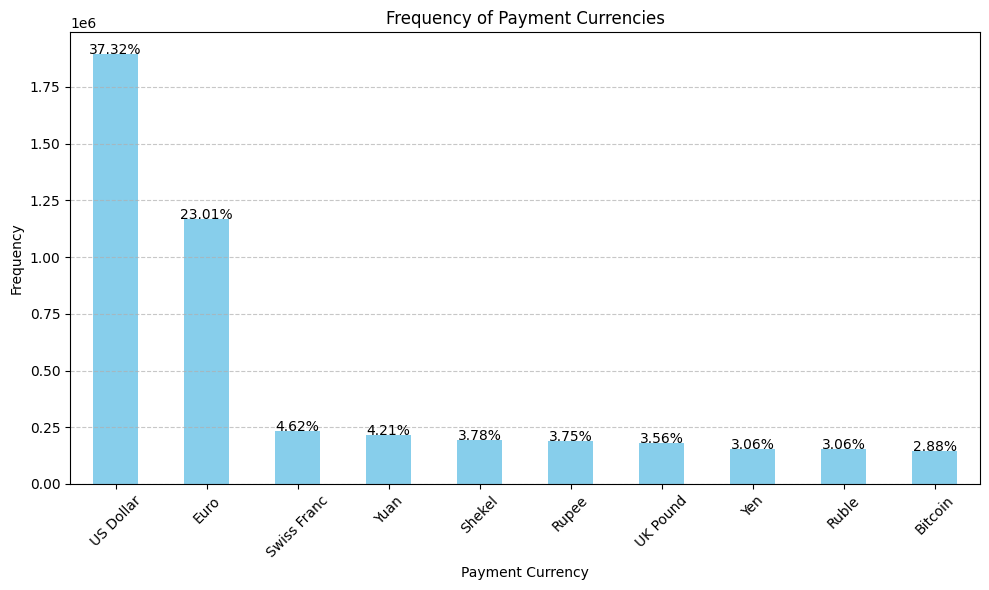

In [53]:
currency_counts = transactions['Payment Currency'].value_counts()[:10]
total_transactions = len(transactions)
currency_percentage = (currency_counts / total_transactions) * 100

plt.figure(figsize=(10, 6))
bars = currency_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Payment Currencies')
plt.xlabel('Payment Currency')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(currency_counts):
    plt.text(i, v + 0.5, f'{currency_percentage.iloc[i]:.2f}%', ha='center')

plt.tight_layout()
plt.show()

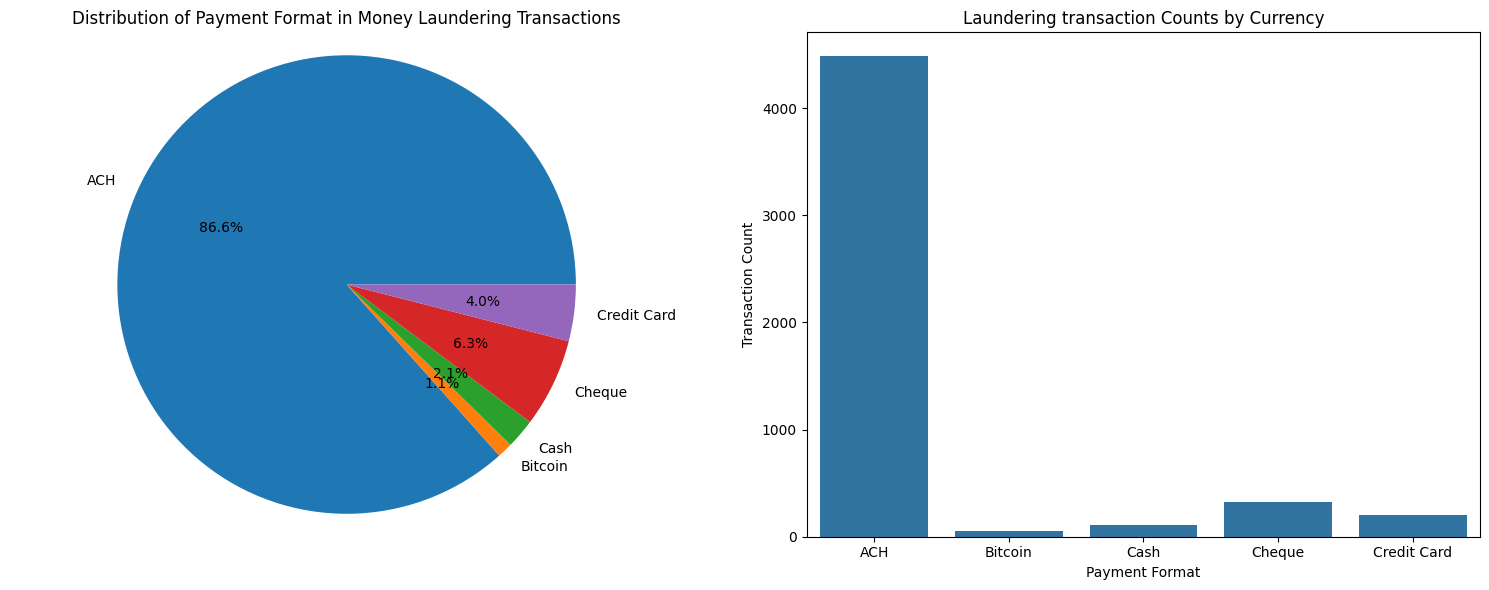

In [58]:
Laundering = transactions[transactions['Is Laundering']==1]
payment_formatL = Laundering.groupby('Payment Format').size().reset_index(name='Transaction Count')

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].pie(payment_formatL['Transaction Count'], labels=payment_formatL['Payment Format'], autopct='%1.1f%%', startangle=0)
axes[0].set_title('Distribution of Payment Format in Money Laundering Transactions')
axes[0].axis('equal')


sns.barplot(x='Payment Format', y='Transaction Count', data=payment_formatL,ax=axes[1])
axes[1].set_title('Laundering transaction Counts by Currency')
axes[1].set_xlabel('Payment Format')
axes[1].set_ylabel('Transaction Count')
plt.tight_layout()
plt.show()

In [74]:
def detect_fan_out(data, account, time_window):
    pattern = data[(data['Account'] == account) &
                   (data['Timestamp'] >= data['Timestamp'].min()) &
                   (data['Timestamp'] <= data['Timestamp'].min() + pd.Timedelta(time_window))]
    if len(pattern['Account.1'].unique()) > 5:
        return pattern

def detect_fan_in(data, account, time_window):
    pattern = data[(data['Account.1'] == account) &
                   (data['Timestamp'] >= data['Timestamp'].min()) &
                   (data['Timestamp'] <= data['Timestamp'].min() + pd.Timedelta(time_window))]
    if len(pattern['Account'].unique()) > 5:
        return pattern

### Illicit account with fan out pattern

In [27]:
fan_out_pattern = detect_fan_out(transactions, '800737690', pd.Timedelta(1, unit='d'))
fan_out_pattern

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
137519,2022-09-01 00:06:00,21174,800737690,21174,800737690,2848.96,Euro,3338.36,US Dollar,ACH,0
137520,2022-09-01 00:06:00,21174,800737690,12,80011F990,2848.96,Euro,2848.96,Euro,ACH,1
137521,2022-09-01 04:33:00,21174,800737690,21174,800737690,8630.40,Euro,10112.97,US Dollar,ACH,0
137522,2022-09-01 04:33:00,21174,800737690,20,80020C5B0,8630.40,Euro,8630.40,Euro,ACH,1
137523,2022-09-01 09:14:00,21174,800737690,21174,800737690,35642.49,Yuan,5321.68,US Dollar,ACH,0
137524,2022-09-01 09:14:00,21174,800737690,20,80006A5E0,35642.49,Yuan,35642.49,Yuan,ACH,1
137525,2022-09-01 09:56:00,21174,800737690,220,8007A5B70,5738987.96,US Dollar,5738987.96,US Dollar,ACH,1
137526,2022-09-01 11:28:00,21174,800737690,1244,80093C0D0,7254.53,US Dollar,7254.53,US Dollar,ACH,1
137527,2022-09-01 13:13:00,21174,800737690,513,80078E200,6990.87,US Dollar,6990.87,US Dollar,ACH,1
137528,2022-09-01 14:11:00,21174,800737690,21174,800737690,12536.92,Euro,14690.55,US Dollar,ACH,0


### Same account as before tested for fan in, no results found

In [30]:
fan_in_pattern = detect_fan_in(transactions, '800737690', pd.Timedelta(1, unit='d'))
fan_in_pattern

### Illicit account
not fan in pattern, maybe something else

In [32]:
fan_in_pattern = detect_fan_in(transactions, '8007A5B70', pd.Timedelta(1, unit='d'))
fan_in_pattern

In [64]:
fan_in_pattern = detect_fan_in(transactions, '80093C0D0', pd.Timedelta(1, unit='d'))
fan_in_pattern

In [76]:
i = 0

fan_in_pattern = None
for account in transactions["Account.1"].unique():
    i += 1
    pattern = detect_fan_in(transactions, account, pd.Timedelta(1, unit='d'))
    if pattern is not None and pattern["Is Laundering"].sum() != 0:
        fan_in_pattern = pattern
        break

fan_in_pattern

KeyboardInterrupt: 

In [84]:
import networkx as nx

def detect_bipartite(data, time_window):
    pattern = data[(data['Timestamp'] >= data['Timestamp'].min()) &
                   (data['Timestamp'] <= data['Timestamp'].min() + pd.Timedelta(time_window))]

    G = nx.Graph()
    for _, row in pattern.iterrows():
        G.add_edge(row['Account'], row['Account.1'], weight=row['Amount Paid'])

    if nx.is_bipartite(G) and pattern is not None:
        return pattern

In [85]:
bipartite_pattern = detect_bipartite(transactions, pd.Timedelta(1, unit='d'))
bipartite_pattern